In [32]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, recall_score
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import yfinance as yf
import matplotlib.pyplot as plt

import datetime as dt
from alive_progress import alive_bar
def get_stock_data(ticker: str, period: str) -> pd.DataFrame:
    '''
    ticker: str - the stock ticker to get data for
    returns: pd.DataFrame - the stock data for the given ticker
    '''
    
    # check if a new day has started
    if os.path.exists(f'data/{ticker}.json'):
        now = dt.datetime.now()
        if now.hour < 9:
            print('Reading from Cache')
            return pd.read_json(f'data/{ticker}.json')
    else:
        os.makedirs('data', exist_ok=True)
        
    data = yf.Ticker(ticker).history(period=period)
    
    data.to_json(f'data/{ticker}.json')
    
    return data

In [33]:
def exponential_smoothing(data: pd.DataFrame, alpha: float) -> pd.DataFrame:
    '''
    data: pd.DataFrame - the stock data to use
    alpha: float - the smoothing factor
    returns: pd.DataFrame - the stock data with the smoothed values
    '''
    
    model = ExponentialSmoothing(data['Close'], trend='add', seasonal='add', seasonal_periods=7)
    model_fit = model.fit(smoothing_level=alpha, smoothing_slope=0.01, smoothing_seasonal=0.01)
    
    data = data.assign(smoothed=model_fit.fittedvalues)
    
    return data

In [34]:
ticker = 'INTC'
data = get_stock_data(ticker, 'max')
data = exponential_smoothing(data, 0.7)
data.tail()

/Users/dennis/lam_projects/LAM-Stock-Predictor/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/8w/kjbqt1yd6l5g3zwqxpy7v97r0000gn/T/ipykernel_13224/3874806468.py:9: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=alpha, smoothing_slope=0.01, smoothing_seasonal=0.01)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,smoothed
Date,,,,,,,,
2024-08-14 00:00:00-04:00,20.490000,20.500000,19.790001,19.920000,56758200,0.0,0.0,19.895102
2024-08-15 00:00:00-04:00,20.320000,21.059999,20.230000,20.690001,84814900,0.0,0.0,19.940689
2024-08-16 00:00:00-04:00,20.530001,20.900000,20.410000,20.870001,48582700,0.0,0.0,20.317176
2024-08-19 00:00:00-04:00,20.889999,21.860001,20.840000,21.520000,65956300,0.0,0.0,20.608984
2024-08-20 00:00:00-04:00,21.209999,21.230000,20.820000,20.990000,84070000,0.0,0.0,21.165917


In [35]:
def rsi(data: pd.DataFrame) -> pd.DataFrame:
    data['Delta'] = data['Close'].diff(1)
    data['Gain'] = data['Delta'].clip(lower=0).round(2)
    data['Loss'] = data['Delta'].clip(upper=0).abs().round(2)
    
    data['Avg_Gain'] = data['Gain'].rolling(window=14, min_periods=14).mean()[:14+1]
    data['Avg_Loss'] = data['Loss'].rolling(window=14, min_periods=14).mean()[:14+1]
    
    avg_gain = data['Avg_Gain'].copy()
    avg_loss = data['Avg_Loss'].copy()
    
    for i in range(14, len(data['Avg_Gain'])-1):
        avg_gain.iloc[i+1] = (avg_gain.iloc[i] * 13 + data['Gain'].iloc[i+1]) / 14
        avg_loss.iloc[i+1] = (avg_loss.iloc[i] * 13 + data['Loss'].iloc[i+1]) / 14  
    
    data['Avg_Gain'] = avg_gain
    data['Avg_Loss'] = avg_loss  
    
    data['RS'] = data['Avg_Gain'] / data['Avg_Loss']
    
    data['RSI'] = 100 - (100 / (1.0 + data['RS']))
    
    data['RSI_Signal'] = np.where(data['RSI'] > 70, -1, np.where(data['RSI'] < 30, 1, 0))
        
    return data
    
data = rsi(data)

data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,smoothed,Delta,Gain,Loss,Avg_Gain,Avg_Loss,RS,RSI,RSI_Signal
Date,,,,,,,,,,,,,,,,
2024-08-14 00:00:00-04:00,20.490000,20.500000,19.790001,19.920000,56758200,0.0,0.0,19.895102,-0.549999,0.00,0.55,0.265002,0.732008,0.362021,26.579706,1
2024-08-15 00:00:00-04:00,20.320000,21.059999,20.230000,20.690001,84814900,0.0,0.0,19.940689,0.770000,0.77,0.00,0.301074,0.679722,0.442937,30.696890,0
2024-08-16 00:00:00-04:00,20.530001,20.900000,20.410000,20.870001,48582700,0.0,0.0,20.317176,0.180000,0.18,0.00,0.292426,0.631170,0.463307,31.661642,0
2024-08-19 00:00:00-04:00,20.889999,21.860001,20.840000,21.520000,65956300,0.0,0.0,20.608984,0.650000,0.65,0.00,0.317967,0.586087,0.542525,35.171227,0
2024-08-20 00:00:00-04:00,21.209999,21.230000,20.820000,20.990000,84070000,0.0,0.0,21.165917,-0.530001,0.00,0.53,0.295255,0.582080,0.507240,33.653584,0


In [36]:
def macd(data: pd.DataFrame) -> pd.DataFrame:
    data['Ema12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['Ema26'] = data['Close'].ewm(span=26, adjust=False).mean()
    
    data['MACD'] = data['Ema12'] - data['Ema26']
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    
    data['MACD_Signal'] = np.where(data['MACD'] > data['Signal'], 1, np.where(data['MACD'] < data['Signal'], -1, 0))
    
    return data

data = macd(data)
def price_rate_of_change(data: pd.DataFrame) -> pd.DataFrame:
    data['Price_Rate_Of_Change'] = (data['Close'] - data['Close'].shift(7)) / data['Close'].shift(7)
    data['Price_Rate_Of_Change_Signal'] = np.where(data['Price_Rate_Of_Change'] > 0, 1, np.where(data['Price_Rate_Of_Change'] < 0, -1, 0))
    
    return data

data = price_rate_of_change(data)
def stochastic_oscillator(data: pd.DataFrame) -> pd.DataFrame:
    data['Lowest_Low'] = data['Low'].rolling(window=14).min()
    data['Highest_High'] = data['High'].rolling(window=14).max()
    
    data['Fast_K'] = 100 * ((data['Close'] - data['Lowest_Low']) / (data['Highest_High'] - data['Lowest_Low']))
    
    data['Fast_D'] = data['Fast_K'].rolling(window=3).mean().round(2)
    
    data['Slow_K'] = data['Fast_D']
    data['Slow_D'] = data['Slow_K'].rolling(window=3).mean().round(2)
    
    data['Stochastic_Signal_Fast'] = np.where(data['Fast_K'] > 80, -1, np.where(data['Fast_K'] < 20, 1, 0))
    data['Stochastic_Signal_Slow'] = np.where(data['Slow_K'] > 80, -1, np.where(data['Slow_K'] < 20, 1, 0))
    
    return data

data = stochastic_oscillator(data)
def william_percent_r(data: pd.DataFrame) -> pd.DataFrame:
    data['Lowest_Low'] = data['Low'].rolling(window=14).min()
    data['Highest_High'] = data['High'].rolling(window=14).max()
    
    data['William_Percent_R'] = ((data['Highest_High'] - data['Close']) / (data['Highest_High'] - data['Lowest_Low'])) * -100
    
    data['William_Percent_R_Signal'] = np.where(data['William_Percent_R'] > -20, -1, np.where(data['William_Percent_R'] < -80, 1, 0))
    
    return data

data = william_percent_r(data)
def on_balance_volume(data: pd.DataFrame) -> pd.DataFrame:
    data['On_Balance_Volume'] = np.where(data['Close'] > data['Close'].shift(1), data['Volume'] + data['Volume'].shift(1), np.where(data['Close'] < data['Close'].shift(1), data['Volume'] - data['Volume'].shift(1), 0))
    
    data['On_Balance_Volume_Signal'] = np.where(data['On_Balance_Volume'] > data['On_Balance_Volume'].shift(1), 1, np.where(data['On_Balance_Volume'] < data['On_Balance_Volume'].shift(1), -1, 0))
    
    return data

data = on_balance_volume(data)

In [37]:
predicators = ['Close', 'Delta', 'RSI_Signal', 'MACD_Signal', 'Price_Rate_Of_Change_Signal', 'Stochastic_Signal_Fast', 'Stochastic_Signal_Slow', 'William_Percent_R_Signal', 'On_Balance_Volume_Signal']
data = data[predicators]
data.tail()

,Close,Delta,RSI_Signal,MACD_Signal,Price_Rate_Of_Change_Signal,Stochastic_Signal_Fast,Stochastic_Signal_Slow,William_Percent_R_Signal,On_Balance_Volume_Signal
Date,,,,,,,,,
2024-08-14 00:00:00-04:00,19.920000,-0.549999,1,-1,-1,1,1,1,-1
2024-08-15 00:00:00-04:00,20.690001,0.770000,0,-1,1,1,1,1,1
2024-08-16 00:00:00-04:00,20.870001,0.180000,0,-1,1,1,1,1,-1
2024-08-19 00:00:00-04:00,21.520000,0.650000,0,-1,1,0,1,0,-1
2024-08-20 00:00:00-04:00,20.990000,-0.530001,0,1,1,1,1,1,-1


In [38]:
# create target column
target_val = data['Delta']
target_val = np.where(target_val > 0, 1, 0)
data['Target'] = target_val
data = data.dropna()

In [39]:
def backtest(data: pd.DataFrame, model: RandomForestClassifier, start: int, step: int, alpha: float) -> pd.DataFrame:
    '''
    data: pd.DataFrame - the stock data to backtest
    model: RandomForestClassifier - the model to use for backtesting
    target: str - the target column to backtest
    returns: pd.DataFrame - the backtested stock data
    '''
    
    avg_precision = []
    avg_roc_auc = []
    avg_recall = []
    
    data_backtest = data.copy()
    
    cut_off = 0
    
    for i in range(start, len(data), step):
        # create the training data
        X_train = data_backtest.drop('Target', axis=1).iloc[cut_off:i]
        y_train = data_backtest['Target'].iloc[cut_off:i]
        # create the testing data
        X_test = data_backtest.drop('Target', axis=1).iloc[i:i+step]
        y_test = data_backtest['Target'].iloc[i:i+step]
        
        cut_off += step
        
        # create the model
        model.fit(X_train, y_train)
        # make predictions
        y_pred = model.predict_proba(X_test)[:, 1]
        # assign the predictions to the data
        y_pred = np.where(y_pred > alpha, 1, 0)
        
        # calculate the metrics
        avg_roc_auc.append(roc_auc_score(y_test, y_pred))
        avg_precision.append(precision_score(y_test, y_pred))
        avg_recall.append(recall_score(y_test, y_pred))
        
    
    return sum(avg_precision) / len(avg_precision), sum(avg_recall) / len(avg_recall), sum(avg_roc_auc) / len(avg_roc_auc)

def hyperparameter_tuning(data: pd.DataFrame, model: RandomForestClassifier, start: int, step: int) -> dict:
    '''
    data: pd.DataFrame - the stock data to backtest
    model: RandomForestClassifier - the model to use for backtesting
    target: str - the target column to backtest
    returns: dict - the hyperparameters for the best model
    '''
    
    params = {
        'n_estimators': [100],
        'max_depth': [5],
        'alpha': [.6],
    }
    
    best_precision = 0
    best_roc_auc = 0
    best_recall = 0
    best_model = None
    
    with alive_bar(len(params['n_estimators']) * len(params['max_depth']) * len(params['alpha']), force_tty = True) as bar:
        for n_estimators in params['n_estimators']:
            for max_depth in params['max_depth']:
                for alpha in params['alpha']:
                    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
                    precision, recall, roc_auc_value = backtest(data, model, start, step, alpha)
                    # check for the ones that have the highest precision and roc auc
                    if roc_auc_value > best_roc_auc and precision > best_precision and recall > best_recall:
                        best_roc_auc = roc_auc_value
                        best_precision = precision
                        best_recall = recall
                        hyperparameters = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'alpha': alpha
                        }
                        best_model = model
                        print(f'Best: ROC AUC: {roc_auc_value:.2f} - Precision: {precision} - Recall: {recall} - n_estimators: {n_estimators} - max_depth: {max_depth} - alpha: {alpha}')
                    bar()
    
    return hyperparameters, best_precision, best_model

In [40]:
data_clean = data.copy()
data_clean.keys()
predictors = ['Target', 'RSI_Signal', 'MACD_Signal', 'Stochastic_Signal_Fast', 'Stochastic_Signal_Slow', 'Price_Rate_Of_Change_Signal' ,'William_Percent_R_Signal', 'On_Balance_Volume_Signal']
data_clean = data_clean[predictors]

# # get the days before the last 90 days for training
X_train = data_clean.iloc[:-90]
X_test_validation = data_clean.iloc[-90:].drop(['Target'], axis=1)[['RSI_Signal', 'MACD_Signal', 'Stochastic_Signal_Fast', 'Stochastic_Signal_Slow', 'Price_Rate_Of_Change_Signal', 'William_Percent_R_Signal', 'On_Balance_Volume_Signal']]
Y_test_validation = data_clean['Target'].iloc[-90:]

In [41]:
hyperparameters_90, best_precision_90, best_model_90 = hyperparameter_tuning(X_train[['Target', 'RSI_Signal', 'MACD_Signal', 'Stochastic_Signal_Fast', 'Stochastic_Signal_Slow', 'Price_Rate_Of_Change_Signal', 'William_Percent_R_Signal', 'On_Balance_Volume_Signal']], RandomForestClassifier(), 900, 90)
print(f'90-Day: Best Hyperparameters: {hyperparameters_90}')

on 0: Best: ROC AUC: 0.78 - Precision: 0.8385369136652828 - Recall: 0.6870044447996122 - n_estimators: 100 - max_depth: 5 - alpha: 0.6
|████████████████████████████████████████| 1/1 [100%] in 10.1s (0.10/s)         
90-Day: Best Hyperparameters: {'n_estimators': 100, 'max_depth': 5, 'alpha': 0.6}


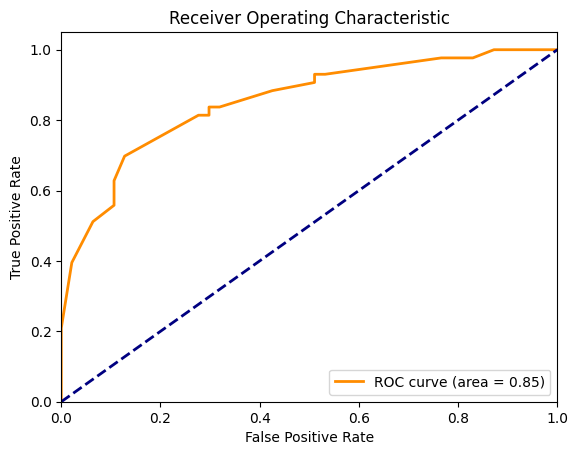

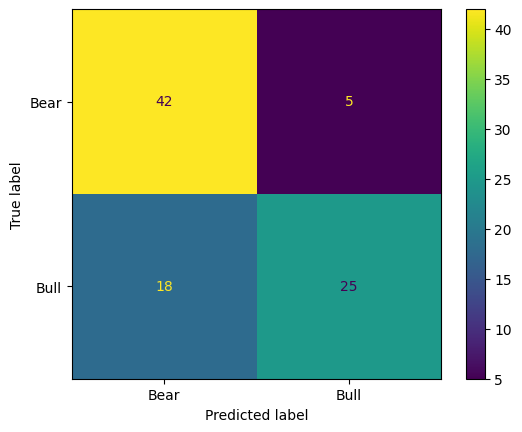

90-Day: Recall: 0.58
90-Day: ROC AUC: 0.85
90-Day: Precision: 0.83


In [44]:
y_pred = best_model_90.predict_proba(X_test_validation)[:, 1]
fpr, tpr, _ = roc_curve(Y_test_validation, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

y_pred = np.where(y_pred > hyperparameters_90['alpha'], 1, 0)
precision = precision_score(Y_test_validation, y_pred)

# plot the confusion matrix
cm = confusion_matrix(Y_test_validation, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bear', 'Bull'])
disp.plot()
plt.show()


print(f'90-Day: Recall: {recall_score(Y_test_validation, y_pred):.2f}')
print(f'90-Day: ROC AUC: {roc_auc:.2f}')
print(f'90-Day: Precision: {precision:.2f}')



In [45]:
for feature_name, importance in zip(best_model_90.feature_names_in_, best_model_90.feature_importances_):
    print(f"{feature_name}: {importance:.4f}")

RSI_Signal: 0.0226
MACD_Signal: 0.0366
Stochastic_Signal_Fast: 0.1783
Stochastic_Signal_Slow: 0.1046
Price_Rate_Of_Change_Signal: 0.0549
William_Percent_R_Signal: 0.1758
On_Balance_Volume_Signal: 0.4273
